# GEDI L4B AGBD biomass data

The [GEDI L4B AGB product](https://daac.ornl.gov/GEDI/guides/GEDI_L4B_Gridded_Biomass.html) provides km x 1 km estimates of mean aboveground biomass density (AGBD) based on observations from 2019-04-18 to 2021-08-04. Each waveform is converted to an AGBD prediction based on estimated forest height.

The sample present within the borders of each 1 km cell is used to statistically infer mean The estimate covers the entire area of the 1 km cell, regardless of whether that area is completely forested or not - no forest mask is applied to filter out non-forest waveforms so that non-forest biomass estimates can be included, and the choice of mask may impact the estimates. To obtain a specific estiamte for the forest area, one can divide the mean 1km AGBD by the fraction of the cell that is forested according to their preferred forest map.

The GEDI data has a number of sources of uncertainty, including the sampling of the 1km area (as opposed to making wall-to-wall observations) and the modelling approach of the biomass values. 

## Exploring the GEDI data

Let's start by loading up the libraries we will need to import and interrogate the GEDI biomass data. It is in [GeoTIFF](https://www.ogc.org/standard/geotiff/) format, a file format used in the geospatial and earth science communities for geographic image data. GDAL (the Geospatial Data Abstraction Library) is a major software library for reading/writing raster & vector geospatial data, and forms the basis of most software for processing such data. the Geospatial Data Abstraction Library is a software library for reading and writing raster and vector geospatial data formats and forms the basis of most software for processing geospatial data.

Aside: 

**Raster** data is any pixelated (or gridded) data where each pixel is associated with a specific geographical location. The value of a pixel can be continuous (e.g. elevation) or categorical (e.g. land use). A geospatial raster differs only a digital photo in that it is accompanied by spatial information that connects the data to a particular location - the spatial extent, cell size, coordinate reference system (CRS), etc. An example of a continuous raster would be maps of tree height derived from LiDAR data, or precipitation maps.

**Vector** data structures represent specific features on the Earth’s surface, and assign attributes to those features. They are composed of discrete x,y geometric locations or vertices that define the shape of the spatial object. The organisation of the vertices determines the type of vector that we are working with - these are  points (defined by a single x, y coordinate), lines (at least 2 points that are connected) or polygons (3 or more points that are connected and closed).


### How to read in GEDI raster data

We can explore the data in one of a couple of ways in Python - using ``rasterio``, which provides a pythonic wrapper around [GDAL](https://gdal.org/index.html) (rasterio allows for reading & writing geospatial data, based on ``numpy`` arrays and GeoJSONs) or using ``xarray`` and ``rioxarray``. ``rasterio`` allows us to open the data as an image and explore that way (see [this tutorial](http://patrickgray.me/open-geo-tutorial/chapter_1_rasterio.html) for example), while ``rioxarray`` allows us to make use of ``rasterio`` for the GDAL capability but also utilise ``xarray``'s array processing abilities. We'll use ``xarray`` and ``rioxarray`` here. This format is particularly useful for raster data, such as what we have here.

In [1]:
import xarray as xr
import rioxarray as rxr

Let's now read in the data and take a look at the format. We can see that it's indexed by x, y coordinates and gridded. It's also in Easting & Northing coordinates ([EPSG 6933](https://spatialreference.org/ref/epsg/6933/)) so we'll want to handle this.

In [36]:
#replace path with the local filepath
geotiff_path = "/Users/aoibheannbrady/Downloads/GEDI_L4B_Gridded_Biomass_V2_1_2299/data/GEDI04_B_MW019MW223_02_002_02_R01000M_MU.tif"
geotiff_da = rxr.open_rasterio(geotiff_path)
geotiff_da

<xarray.DataArray (band: 1, y: 14616, x: 34704)>
[507233664 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -1.737e+07 -1.737e+07 ... 1.737e+07 1.737e+07
  * y            (y) float64 7.314e+06 7.313e+06 ... -7.313e+06 -7.314e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

## Wrangling raster data

We'll reproject the data to classic [EPSG 4326](https://epsg.io/4326), using rioxarray's ``.reproject`` function.

In [6]:
geotiff_da=geotiff_da.rio.reproject("EPSG:4326")
geotiff_da

<xarray.DataArray (band: 1, y: 16086, x: 34047)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)
Coordinates:
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 85.04 85.03 85.02 85.01 ... -85.01 -85.02 -85.04
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

When you use ``rioxarray`` you can view the spatial extent (or bounds) and CRS of the data that you just opened above. You can also check what the ``nodata`` value is.

In [37]:
print("The CRS for this data is:", geotiff_da.rio.crs)
print("The spatial extent is:", geotiff_da.rio.bounds())
print("The no data value is:", geotiff_da.rio.nodata)

The CRS for this data is: EPSG:6933
The spatial extent is: (-17367530.4451615, -7314540.83064014, 17367530.44516536, 7314540.8306386)
The no data value is: -9999.0


Looking at a (very rough!) histogram of the data, we have *a lot* of ``nodata`` values.

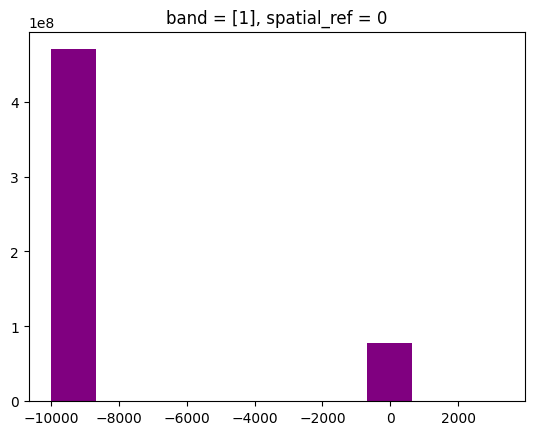

In [8]:
import matplotlib.pyplot as plt
geotiff_da.plot.hist(color="purple")
plt.show()

## Vector data & clipping to boundaries

The GEDI biomass data layer above is a global layer, which will be hard to visualise in terms of compute. In any case, for our challenge we are interested in the legal Amazon region, so we can clip the dataset to this boundary. This is in another file format, a shapefile, which is a polygon, multipolygon or series of polygons which represent some area. As mentioned, a polygon is a vector data format, which we can read in tabular format using [``geopandas``](https://geopandas.org/en/stable/), which extends the ``pandas`` universe in Python to allow for geospatial data.

<AxesSubplot:>

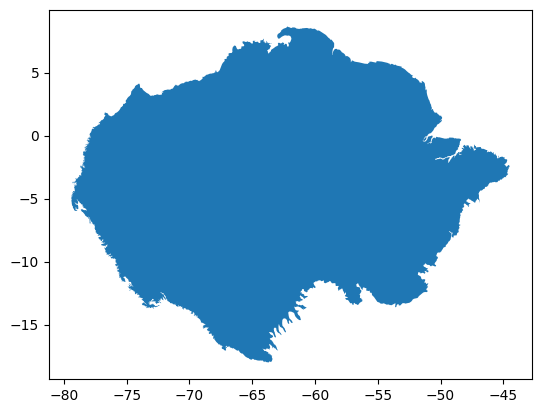

In [9]:
import geopandas as gpd
#replace path with the local filepath
gdf = gpd.read_file('/Users/aoibheannbrady/Downloads/Amazon_forest_boundary.gpkg')
gdf.plot()



Let's now clip the GEDI data to the legal Amazon, represented by the ``gdf`` object. This is easy to do using ``xarray``'s ``.rio.clip()``. It is already in the desired CRS, so we don't need to reproject.

In [10]:
gedi_amazon = geotiff_da.rio.clip(gdf.geometry.values, gdf.crs)

Now we're in a position where we can plot the data as it is of a reasonable size. Let's do this using ``matplotlib``'s ``.plot()`` command.

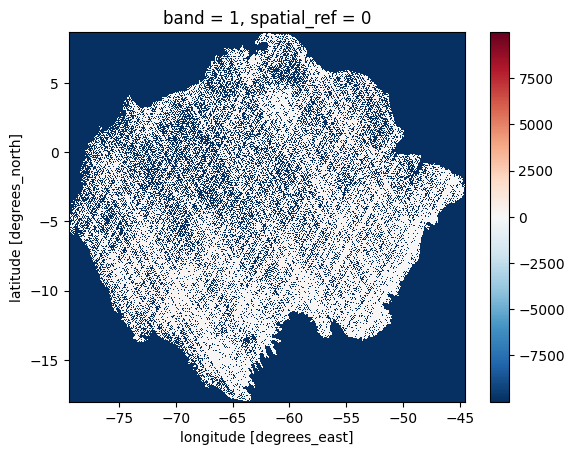

In [12]:
gedi_amazon.plot()

We mentioned before that there were lots of nodata values, which were encoded as -9999.0. We can filter these out.

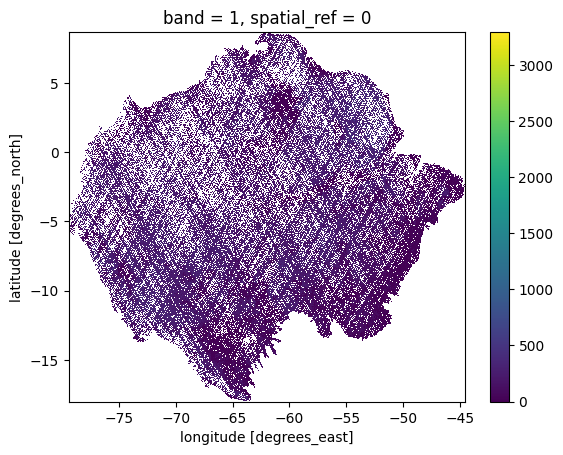

In [33]:
gedi_amazon_filtered=gedi_amazon.where(gedi_amazon != -9999.)
gedi_amazon_filtered.plot()

Let's get some summary statistics of the data now we have converted the nodata values to NaNs. For some simple checks of mean, max, etc, we'll use ``numpy``.

In [35]:
import numpy as np
print("The maximum AGBD value for this data is:", np.nanmax(gedi_amazon_filtered.values))
print("The median AGBD value for this data is:", np.nanmedian(gedi_amazon_filtered.values))
print("The mean AGBD value for this data is:", np.nanmean(gedi_amazon_filtered.values))
print("The standard deviation of AGBD for this data is:", np.nanstd(gedi_amazon_filtered.values))


The maximum AGBD value for this data is: 3294.5596
The median AGBD value for this data is: 173.24054
The mean AGBD value for this data is: 163.58609
The standard deviation of AGBD for this data is: 103.659874


Let's also look at the histogram of the data now we have done this - this looks much more sensible.

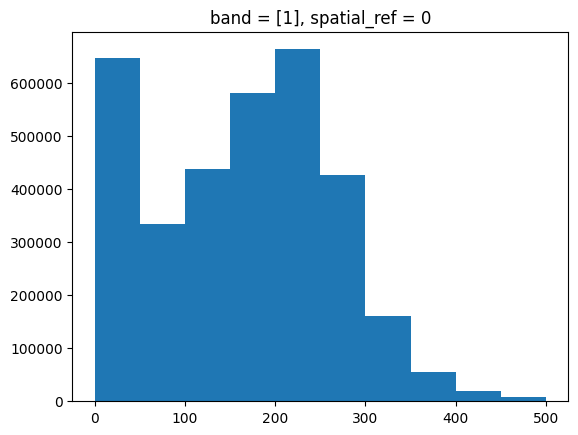

In [32]:
gedi_amazon_filtered.plot.hist(range=(0,500))
plt.show()